# Step 10 - Geodesic distances 

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import pandas as pd

from scipy import sparse
#from scipy.sparse.linalg import splu
#from scipy.sparse.linalg import spilu
#from util import veclen, normalized

from skimage import measure
from scipy.spatial.distance import cdist

from scikits.umfpack import spsolve, splu
from numpy.linalg import norm


C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# original resolution 120/4,80
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  theano_optimizer='fast_compile')

interp_data_grad = gp.InterpolatorData(geo_data, u_grade=[1], output='gradients', compile_theano=True,
                                  theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [4]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [5]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0], 'grad': lith_block[1]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

In [6]:
def computeAB(points, faces):
    """
    Compute matrices for the Laplace-Beltrami operator.
    The matrices correspond to A and B from Reuter's 2009 article.
    Note ::
        All points must be on faces. Otherwise, a singular matrix error
        is generated when inverting D.
    Parameters
    ----------
    points : list of lists of 3 floats
        x,y,z coordinates for each vertex
    faces : list of lists of 3 integers
        each list contains indices to vertices that form a triangle on a mesh
    Returns
    -------
    A : csr_matrix
    B : csr_matrix
    """

    points = np.array(points)
    faces = np.array(faces)
    nfaces = faces.shape[0]

    # Linear local matrices on unit triangle:
    tB = (np.ones((3,3)) + np.eye(3)) / 24.0

    tA00 = np.array([[ 0.5,-0.5, 0.0],
                     [-0.5, 0.5, 0.0],
                     [ 0.0, 0.0, 0.0]])

    tA11 = np.array([[ 0.5, 0.0,-0.5],
                     [ 0.0, 0.0, 0.0],
                     [-0.5, 0.0, 0.5]])

    tA0110 = np.array([[ 1.0,-0.5,-0.5],
                       [-0.5, 0.0, 0.5],
                       [-0.5, 0.5, 0.0]])

    # Replicate into third dimension for each triangle
    # (for tB, 1st index is the 3rd index in MATLAB):
    tB = np.array([np.tile(tB, (1, 1)) for i in range(nfaces)])
    tA00 = np.array([np.tile(tA00, (1, 1)) for i in range(nfaces)])
    tA11 = np.array([np.tile(tA11, (1, 1)) for i in range(nfaces)])
    tA0110 = np.array([np.tile(tA0110,(1, 1)) for i in range(nfaces)])

    # Compute vertex coordinates and a difference vector for each triangle:
    v1 = points[faces[:, 0], :]
    v2 = points[faces[:, 1], :]
    v3 = points[faces[:, 2], :]
    v2mv1 = v2 - v1
    v3mv1 = v3 - v1

    def reshape_and_repeat(A):
        """
        For a given 1-D array A, run the MATLAB code below.
            M = reshape(M,1,1,nfaces);
            M = repmat(M,3,3);
        Please note that a0 is a 3-D matrix, but the 3rd index in NumPy
        is the 1st index in MATLAB.  Fortunately, nfaces is the size of A.
        """
        return np.array([np.ones((3,3))*x for x in A])

    # Compute length^2 of v3mv1 for each triangle:
    a0 = np.sum(v3mv1 * v3mv1, axis=1)
    a0 = reshape_and_repeat(a0)

    # Compute length^2 of v2mv1 for each triangle:
    a1 = np.sum(v2mv1 * v2mv1, axis=1)
    a1 = reshape_and_repeat(a1)

    # Compute dot product (v2mv1*v3mv1) for each triangle:
    a0110 = np.sum(v2mv1 * v3mv1, axis=1)
    a0110 = reshape_and_repeat(a0110)

    # Compute cross product and 2*vol for each triangle:
    cr  = np.cross(v2mv1,v3mv1)
    vol = np.sqrt(np.sum(cr*cr, axis=1))
    # zero vol will cause division by zero below, so set to small value:
    vol_mean = 0.001*np.mean(vol)
    vol = [vol_mean if x == 0 else x for x in vol]
    vol = reshape_and_repeat(vol)

    # Construct all local A and B matrices (guess: for each triangle):
    localB = vol * tB
    localA = (1.0/vol) * (a0*tA00 + a1*tA11 - a0110*tA0110)

    # Construct row and col indices.
    # (Note: J in numpy is I in MATLAB after flattening,
    #  because numpy is row-major while MATLAB is column-major.)
    J = np.array([np.tile(x, (3,1)) for x in faces])
    I = np.array([np.transpose(np.tile(x, (3,1))) for x in faces])

    # Flatten arrays and swap I and J:
    J_new = I.flatten()
    I_new = J.flatten()
    localA = localA.flatten()
    localB = localB.flatten()

    # Construct sparse matrix:
    A = sparse.csr_matrix((localA, (I_new, J_new)))
    B = sparse.csr_matrix((localB, (I_new, J_new)))

    return A, B

In [7]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors"""
    return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        
        
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        
        # jan test
        #cotan = np.nan_to_num(cotan)
        #if np.isnan(np.sum(cotan)):
            #print("Nan in cotan")
        
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n)) 
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    
    #test
    L = np.nan_to_num(L)
    
    L = L.tocsr()
    
    test = L.toarray()
    if np.isfinite(np.linalg.cond(test)):
        B = np.linalg.inv(test)
    else:
        # handle it
        print("Singular Matrix")
    
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    #print("call veclen for triangle area:")
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc  
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """
    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        
        #print("call veclen for self.triangle_area:")
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        
        # error might be here!!!
        
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        

        #print("call veclen for h:")  
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        
        # Jan: m is constant optimized at 1, here 10 is used
        # Jan: h is mean distance between nodes/length of edges
        t = m * h ** 2
        
        # pre-factorize poisson systems
        #Lc, A = compute_mesh_laplacian(verts, tris) 
        Lc, A = computeAB(verts, tris) 
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve
        
        '''
        # Jans call, adding c to diagional
        Lc, A = compute_mesh_laplacian(verts, tris) 
        c = 0.00001
        Lc2 = Lc.toarray() + c*np.eye(len(Lc.toarray()))
        A2 = A.toarray() + c*np.eye(len(A.toarray()))
        sLc = sparse.csr_matrix(Lc2)
        sA = sparse.csr_matrix(A2)
        self._factored_AtLc = splu((sA - t * sLc).tocsc()).solve
        self._factored_L = splu(sLc.tocsc()).solve
        '''
    
    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

In [8]:
# create domain data for certain lithology
domain_data = init_domain(lith_block, geo_data.grid, formation=3)

# set test points
rand_ind1 = np.random.randint(1, len(domain_data))
rand_ind2 = np.random.randint(1, len(domain_data))

pointA = np.array([[domain_data.X[rand_ind1], domain_data.Y[rand_ind1], domain_data.Z[rand_ind1]]])
pointB = np.array([[domain_data.X[rand_ind2], domain_data.Y[rand_ind2], domain_data.Z[rand_ind2]]])

In [9]:
def closest_node(node, nodes):
        closest_ind = cdist(node, nodes).argmin()
        
        dist = cdist(node, nodes)[0][closest_ind] 
    
        return closest_ind, dist

In [10]:
def perpendicular_dist(start_point, grad_val1, grad_val2, interp_data_grad):
    
    step_size = 25 # length of vector
    step = 0
    a = start_point
    
    if grad_val1 < grad_val2:
        #print("loop to bigger")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] > grad_val2:
                break
    
            step += 1
            
    else:
        #print("loop to smaller")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            grad_vec_norm = grad_vec_norm*(-1)
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] < grad_val2:
                break
    
            step += 1
    
    dist = step*step_size
    point = a
    
    return dist, point


In [11]:
def parallel_dist(vertices, simplices, point1, point2):
    
    compute_distance = GeodesicDistanceComputation(vertices, simplices)
    
    distance_of_each_vertex_to_vertex_0 = compute_distance(point1)
    
    dist = distance_of_each_vertex_to_vertex_0[point2]
    
    return dist

In [12]:
def check_mesh(verts, tris):
    '''
    Functions that checks if any vertices in a mesh are not referenced by a face
    '''
    for i in range (len(verts)):
        if i not in (tris):
            print("Unreferenced:", i)
    x=1
    return x

In [13]:
def get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad):

    # get resolution of orginal grid and reshape the gradients accordingly
    res = gp.get_resolution(geo_data)
    a = lith_block[1].reshape(res)
    #potential_block = lith_block[1]
    
    # get gradient value at the two locations 
    gradA = gp.compute_model_at(pointA, interp_data)
    gradB = gp.compute_model_at(pointB, interp_data)
    
    # solution for matrix problem ?
    #valueA = np.round(gradA[0][1], 2)
    #valueB = np.round(gradB[0][1], 2)
    
    valueA = gradA[0][1]
    valueB = gradB[0][1]
    #print(pointA)
    #print(pointB)

    # get two mesh planes, one for each point
    # I need to check why step size 2 works but one doesnt
    
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            a,
            valueA,
            step_size=2,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            a,
            valueB,
            step_size=2,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    
    '''
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            potential_block.reshape(interp_data.geo_data_res.resolution[0],
                                    interp_data.geo_data_res.resolution[1],
                                    interp_data.geo_data_res.resolution[2]),
            valueA,
            step_size=2,
            spacing=((interp_data.geo_data_res.extent[1] - interp_data.geo_data_res.extent[0]) / interp_data.geo_data_res.resolution[0],
                     (interp_data.geo_data_res.extent[3] - interp_data.geo_data_res.extent[2]) / interp_data.geo_data_res.resolution[1],
                     (interp_data.geo_data_res.extent[5] - interp_data.geo_data_res.extent[4]) / interp_data.geo_data_res.resolution[2]))

    
    vertices_pA = interp_data.rescaling_factor * vertices_pA + np.array([interp_data._geo_data.extent[0],
                                                                            interp_data._geo_data.extent[2],
                                                                            interp_data._geo_data.extent[4]]).reshape(1, 3)
    
    
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            potential_block.reshape(interp_data.geo_data_res.resolution[0],
                                    interp_data.geo_data_res.resolution[1],
                                    interp_data.geo_data_res.resolution[2]),
            valueB,
            step_size=2,
            spacing=((interp_data.geo_data_res.extent[1] - interp_data.geo_data_res.extent[0]) / interp_data.geo_data_res.resolution[0],
                     (interp_data.geo_data_res.extent[3] - interp_data.geo_data_res.extent[2]) / interp_data.geo_data_res.resolution[1],
                     (interp_data.geo_data_res.extent[5] - interp_data.geo_data_res.extent[4]) / interp_data.geo_data_res.resolution[2]))

    
    vertices_pB = interp_data.rescaling_factor * vertices_pB + np.array([interp_data._geo_data.extent[0],
                                                                            interp_data._geo_data.extent[2],
                                                                            interp_data._geo_data.extent[4]]).reshape(1, 3)
    
    '''
    
    #x = check_mesh(vertices_pA, simplices_pA)
    #x = check_mesh(vertices_pB, simplices_pB)
    
    # select closest points in mesh
    closeA, distA = closest_node(pointA, vertices_pA)
    closeB, distB = closest_node(pointB, vertices_pB)
    
    #print(distA)
    #print(distB)

    # calculate perpendicular distance towards each triangular mesh respectively
    dist_perpA, pointA2 = perpendicular_dist(pointA, gradA[0][1], gradB[0][1], interp_data_grad)
    dist_perpB, pointB2 = perpendicular_dist(pointB, gradB[0][1], gradA[0][1], interp_data_grad)
    closeA2, distA2 = closest_node(pointA2, vertices_pB)
    closeB2, distA2 = closest_node(pointB2, vertices_pA)
    
    # calculate parallel distance
    dist_paraA = parallel_dist(vertices_pA, simplices_pA, closeA, closeB2)
    dist_paraB = parallel_dist(vertices_pB, simplices_pB, closeB, closeA2)
    
    # calculate full distance
    total_dist = 0.5*(dist_paraA+dist_paraB)+0.5*(dist_perpA+dist_perpB)

    
    check, dist_cdist = closest_node(pointA, pointB)
    
    #print("cdist:", dist_cdist)
    #print("dist_perpA:", dist_perpA)
    #print("dist_perpB:", dist_perpB)
    #print("dist_paraA", dist_paraA)
    #print("dist_paraB", dist_paraB)
    #print("total_dist", total_dist)
    
    return vertices_pA, simplices_pA, vertices_pB, simplices_pB, closeA, closeB, closeA2, closeB2, total_dist

In [14]:
vertices1, simplices1, vertices2, simplices2, closeA, closeB, closeA2, closeB2, dist_result = get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 2.71e+14)
  warnings.warn(msg, UmfpackWarning)
C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 6.73e+14)
  warnings.warn(msg, UmfpackWarning)


In [15]:
ver , sim = gp.get_surfaces(interp_data, lith_block[1])

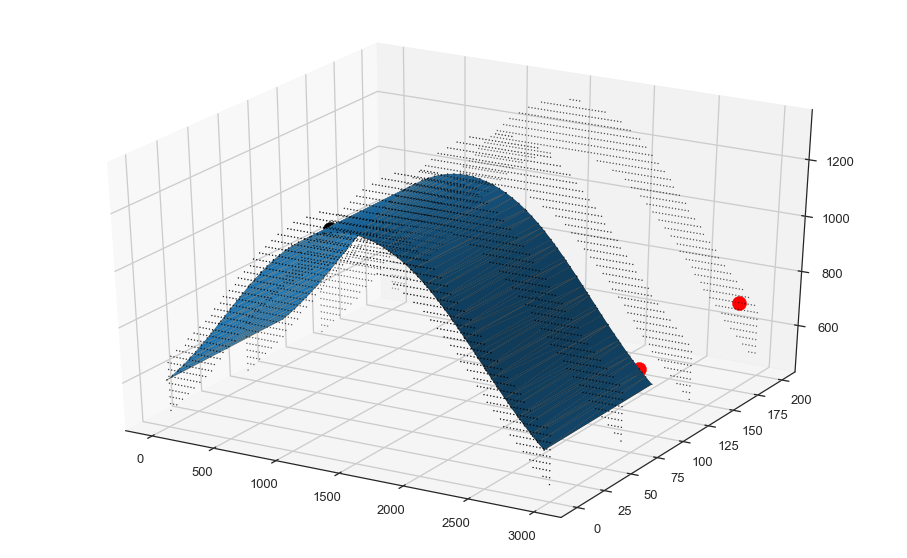

In [16]:
fig = plt.figure(figsize=(16,10))
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[1])
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

ax.scatter3D(xs=pointA[0][0], ys=pointA[0][1], zs=pointA[0][2], s=200, c='black')
ax.scatter3D(xs=pointB[0][0], ys=pointB[0][1], zs=pointB[0][2], s=200, c='red')
ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

ax.plot_trisurf(vertices1[:,0], vertices1[:,1], vertices1[:,2], triangles=simplices1)
ax.plot_trisurf(vertices2[:,0], vertices2[:,1], vertices2[:,2], triangles=simplices2)

ax.scatter3D(vertices1[:,0], vertices1[:,1], vertices1[:,2], s=1, c='black')

ax.scatter3D(xs=vertices1[closeA,0], ys=vertices1[closeA,1], zs=vertices1[closeA,2], s=200, c='black')
ax.scatter3D(xs=vertices2[closeB,0], ys=vertices2[closeB,1], zs=vertices2[closeB,2], s=200, c='red')

#ax.scatter3D(xs=vertices1[closeA2,0], ys=vertices1[closeA2,1], zs=vertices1[closeA2,2], s=200, c='black')
#ax.scatter3D(xs=vertices2[closeB2,0], ys=vertices2[closeB2,1], zs=vertices2[closeB2,2], s=200, c='red')

# trying to plot arrows
#soa = np.array([[vertices1[closeA,0], vertices1[closeA,1], vertices1[closeA,2], grad[0][2]*100, grad[0][3]*100, grad[0][4]*100]])

#X, Y, Z, U, V, W = zip(*soa)
#ax.quiver(X, Y, Z, U, V, W)

In [17]:
# following part is just for testing the geodesic distance algorithm

print(sim[1].shape)
print(ver[1].shape)

(1078, 3)
(713, 3)


In [18]:
print(sim[1].shape)
print(simplices1.shape)

(1078, 3)
(176, 3)


In [19]:
compute_distance = GeodesicDistanceComputation(ver[1], sim[1])

In [20]:
point = 20

In [21]:
distance_of_each_vertex_to_vertex_0 = compute_distance(point)

C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.94e+14)
  warnings.warn(msg, UmfpackWarning)


In [22]:
distance_of_each_vertex_to_vertex_0[20]

362.28725631535997

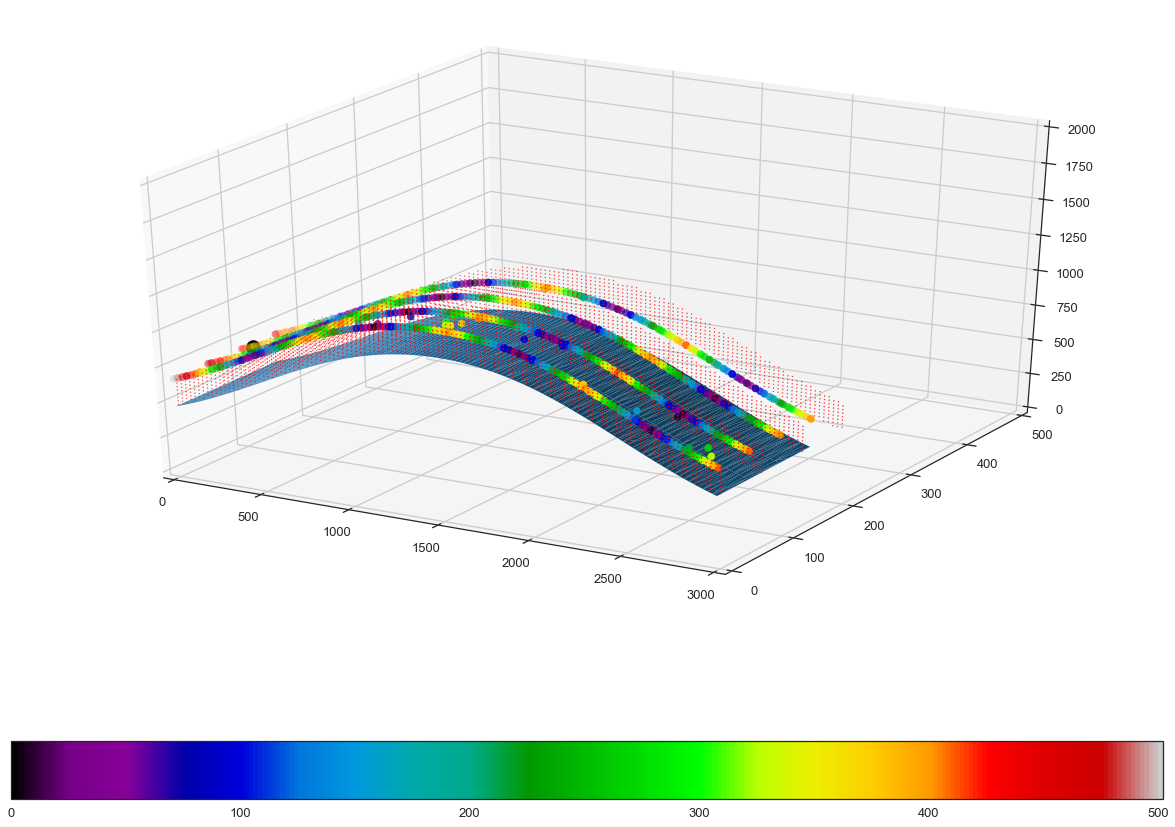

In [23]:
fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,500)
a = ax.scatter3D(xs=ver[1][:,0],ys=ver[1][:,1],zs=ver[1][:,2], c=distance_of_each_vertex_to_vertex_0, cmap='nipy_spectral', s=50)
# a = ax.scatter3D(xs=ver[2][:,0],ys=ver[2][:,1],zs=ver[2][:,2], c='black', cmap='nipy_spectral', s=50)
b = ax.scatter3D(xs=ver[1][point][0],ys=ver[1][point][1],zs=ver[1][point][2], c='black', s=200)
c = ax.scatter3D(xs=domain_data.X,ys=domain_data.Y,zs=domain_data.Z, c='red', s=1)
#d = ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[2])
e = ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

fig.colorbar(a, orientation='horizontal')

In [24]:
def calculate_distance_set(point, points):
    result = np.zeros((len(points)))
    for i in range (len(points)):
        print("Run:", i)
        result[i] = get_distance(point, points[[i]], geo_data, interp_data, interp_data_grad)[8]
    
    return result

In [25]:
pointA = np.array([[domain_data.X[rand_ind1], domain_data.Y[rand_ind1], domain_data.Z[rand_ind1]]])
pointB = np.array([[domain_data.X[rand_ind2], domain_data.Y[rand_ind2], domain_data.Z[rand_ind2]]])

In [26]:
point = np.array([[domain_data.X[10], domain_data.Y[10], domain_data.Z[10]]])
print(point)

n = 50

dist_points = np.zeros((n, 3))
for i in range (n):
    rand = np.random.randint(0,len(domain_data))
    dist_points[i][0] = domain_data.X[rand]
    dist_points[i][1] = domain_data.Y[rand]
    dist_points[i][2] = domain_data.Z[rand]                          
                      


[[ 12.5      66.94444 535.5485 ]]


In [27]:
dist_points2 = np.array([dist_points[3]])
print(dist_points2)

[[337.5        133.05555725 786.60339355]]


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
%%time
test = calculate_distance_set(point, dist_points)
print(test)

Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19
Run: 20
Run: 21
Run: 22
Run: 23
Run: 24
Run: 25
Run: 26
Run: 27
Run: 28
Run: 29
Run: 30
Run: 31
Run: 32
Run: 33
Run: 34
Run: 35
Run: 36
Run: 37
Run: 38
Run: 39
Run: 40
Run: 41
Run: 42
Run: 43
Run: 44
Run: 45
Run: 46
Run: 47
Run: 48
Run: 49
[713.99703111 104.61507562 161.80721691 757.30858543 630.27291076
 219.03429098 235.27292602          nan 830.34536206 622.96567864
 311.22403364  99.32151052          nan 697.10258271 731.78217878
          nan 797.53850194 253.75956248 228.6189326  254.82870637
 723.19375055 791.57610048  36.47052003 778.32927353 209.76452164
 374.6748673  792.85706154 799.52552985 225.04148543 321.51013866
 278.75956248 683.70432114 115.14262561 803.29885545          nan
 273.09213937 655.68733706 298.28629233 804.24466832 879.2271097
          nan 114.70645917 871.50485043 312.94715634          nan
 161.46245793 795

In [30]:
%%time
compare = cdist(point, dist_points)
print(compare[0])

[ 132.222229    649.14257843 2292.52765844  415.96181016 2682.49846203
  734.3079416  2556.04851018  629.43219619   83.01700527 1266.26091534
 2013.34439154  989.43661262 2002.07369141 2728.69067652 2754.12241576
 1379.80024028 2714.86855407  594.5852541  2100.33595048 2500.70622526
 1906.28654379  305.58793563  853.36025409 1383.85895868 1217.79601737
 1863.90433662  160.21313628  182.06082603  614.74110355 1208.08858297
  609.76215767 1394.33878199  754.62623969 1760.71094286  618.97916914
 1986.47139435 1930.688495   1125.62698301 1795.38882314  297.3986866
 1156.62945913  998.76358423  182.31798374 1175.18875104 1272.58544065
 1036.84798508  160.21313837 1931.82005999 1478.53596526  125.3378045 ]
Wall time: 0 ns


In [31]:
print(test-compare[0])

[  581.77480211  -544.52750281 -2130.72044153   341.34677526
 -2052.22555127  -515.27365062 -2320.77558416            nan
   747.32835679  -643.2952367  -1702.12035791  -890.11510209
            nan -2031.58809381 -2022.34023698            nan
 -1917.33005214  -340.82569162 -1871.71701788 -2245.87751889
 -1183.09279324   485.98816485  -816.88973406  -605.52968515
 -1008.03149573 -1489.22946932   632.64392526   617.46470382
  -389.69961812  -886.57844431  -331.00259519  -710.63446085
  -639.48361409  -957.41208741            nan -1713.37925498
 -1275.00115794  -827.34069068  -991.14415482   581.8284231
            nan  -884.05712506   689.18686669  -862.2415947
            nan  -875.38552715   634.88459707 -1296.79102436
  -757.13268728   724.87503156]


In [32]:
#print(dist_points[47][0])
#print(point[0][0])

print(test[2])
print(test[22])
print(test[29])
print(test[44])

print(compare[0][2])
print(compare[0][22])
print(compare[0][29])
print(compare[0][44])

161.80721690788968
36.47052002850735
321.5101386567768
nan
2292.527658439426
853.3602540858548
1208.0885829687024
1272.585440652225


IndexError: index 91 is out of bounds for axis 0 with size 50

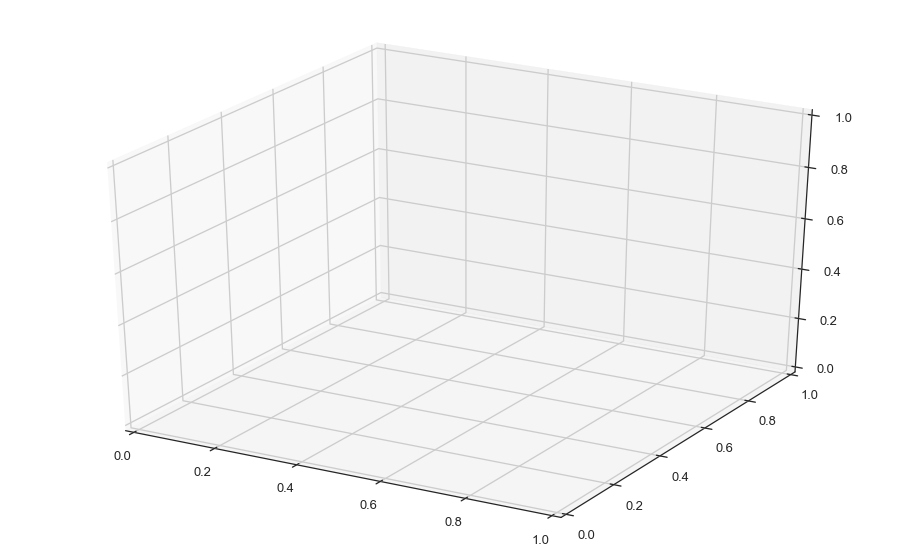

In [33]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(dist_points[91][0], dist_points[91][1], dist_points[91][2], s=100, c='black')
ax.scatter3D(point[0][0], point[0][1], point[0][2], s=100, c='red')

ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

In [ ]:
# this is the one where it doesnt work
test_pointA = np.array([[1875., 125., 1250.]])

# for this one both options should work
#test_pointA = np.array([[312.5, 0.83333331, 635.97045898]])
print(test_pointA)

gradA = gp.compute_model_at(test_pointA, interp_data)
#gradB = gp.compute_model_at(pointB, interp_data)
    
# solution for matrix problem ?
valuetestA1 = np.round(gradA[0][1], 2)
valuetestA2 = gradA[0][1]

print(valuetestA1)
print(valuetestA2)

restest = gp.get_resolution(geo_data)
atest1 = lith_block[1].reshape(restest)
atest2 = lith_block[1].reshape(restest)

In [ ]:
vertices_testpA1, simplices_testpA1, normalstestA1, valuestestA1 = measure.marching_cubes_lewiner(
            atest1,
            valuetestA1,
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))

vertices_testpA2, simplices_testpA2, normalstestA2, valuestestA2 = measure.marching_cubes_lewiner(
            atest2,
            valuetestA2,
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))


In [ ]:
# scalar field value rounded
print(vertices_testpA1.shape)
print(simplices_testpA1.shape)

# scalar field value original
print(vertices_testpA2.shape)
print(simplices_testpA2.shape)

#x = (simplices_testpA1==simplices_testpA2).all()
#print(x)


In [ ]:
fig = plt.figure(figsize=(16,10))
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[1])
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

# points
#ax.scatter3D(xs=pointA[0][0], ys=pointA[0][1], zs=pointA[0][2], s=200, c='black')
#ax.scatter3D(xs=pointB[0][0], ys=pointB[0][1], zs=pointB[0][2], s=200, c='red')
#ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

#ax.plot_trisurf(vertices_testpA1[:,0], vertices_testpA1[:,1], vertices_testpA1[:,2], triangles=simplices_testpA1)#
#ax.plot_trisurf(vertices_testpA2[:,0], vertices_testpA2[:,1], vertices_testpA2[:,2], triangles=simplices_testpA2)

ax.scatter3D(vertices_testpA1[:,0], vertices_testpA1[:,1], vertices_testpA1[:,2], s=100, c='black')
ax.scatter3D(vertices_testpA2[:,0], vertices_testpA2[:,1], vertices_testpA2[:,2], s=100, c='red')

#closest points
#ax.scatter3D(xs=vertices1[closeA,0], ys=vertices1[closeA,1], zs=vertices1[closeA,2], s=200, c='black')
#ax.scatter3D(xs=vertices2[closeB,0], ys=vertices2[closeB,1], zs=vertices2[closeB,2], s=200, c='red')

In [ ]:
point=10

In [ ]:
compute_distancetestA1 = GeodesicDistanceComputation(vertices_testpA1, simplices_testpA1)

In [ ]:
distance_of_each_vertex_to_vertex_0 = compute_distancetestA1(point)
print(distance_of_each_vertex_to_vertex_0)

In [ ]:
compute_distancetestA2 = GeodesicDistanceComputation(vertices_testpA2, simplices_testpA2)

In [ ]:
distance_of_each_vertex_to_vertex_0 = compute_distancetestA2(point)
print(distance_of_each_vertex_to_vertex_0)